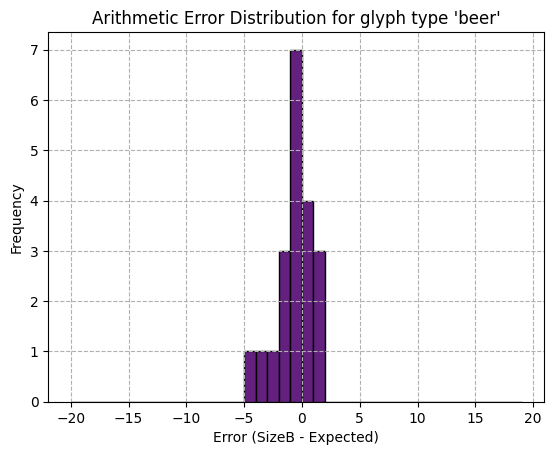

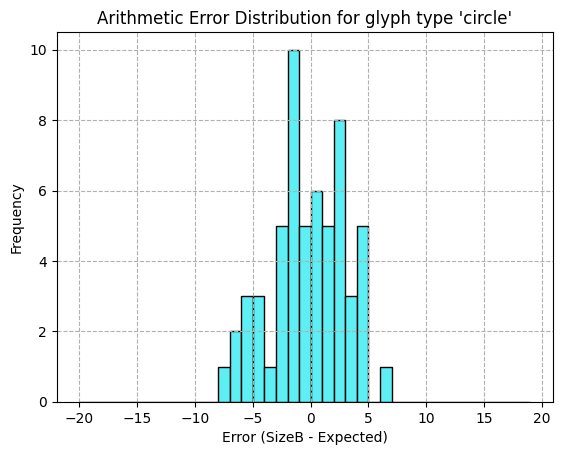

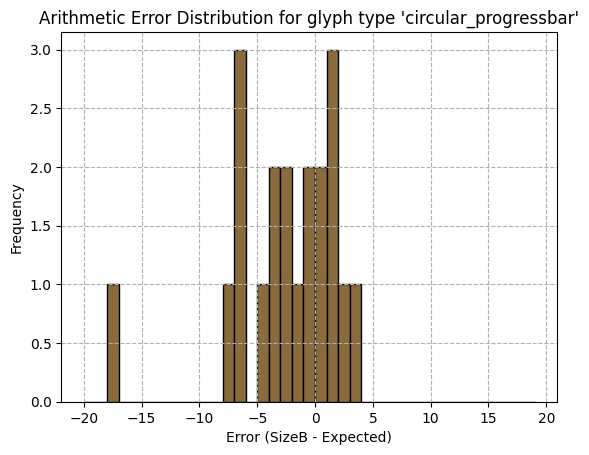

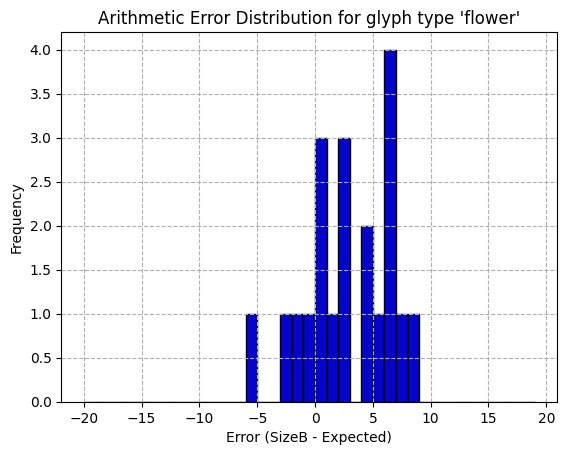

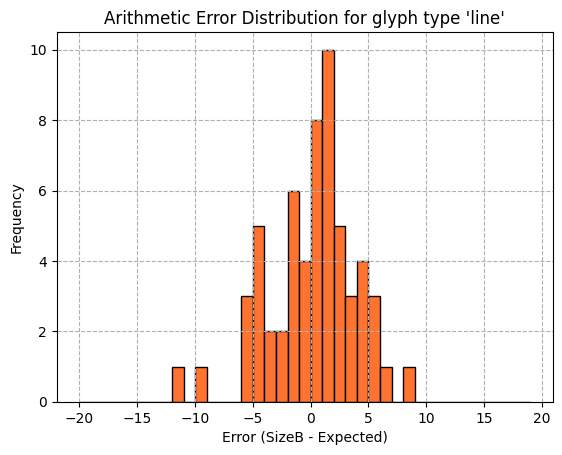

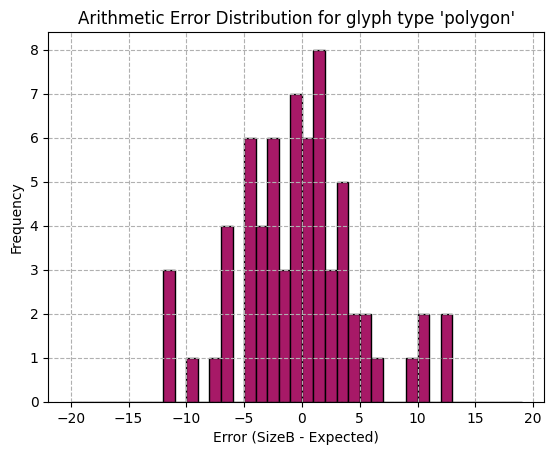

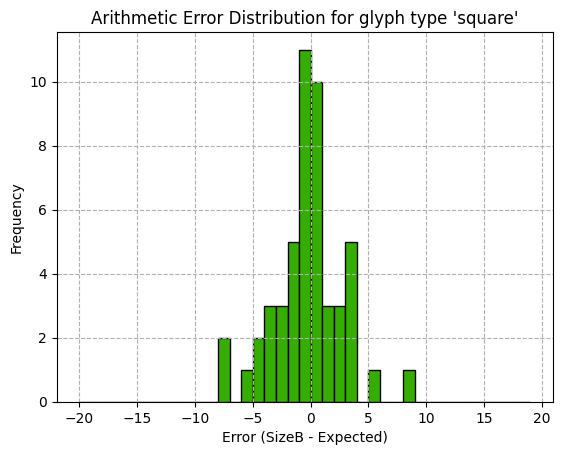

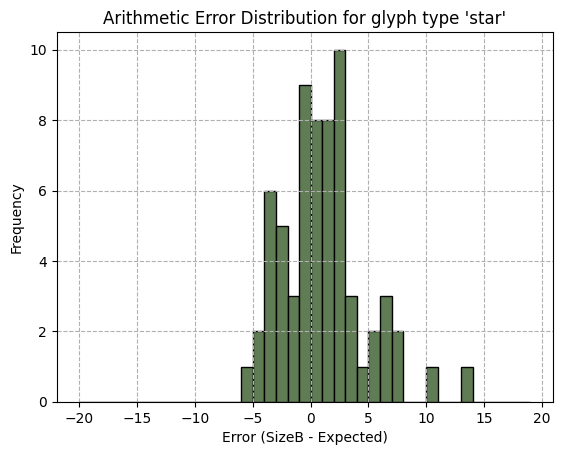

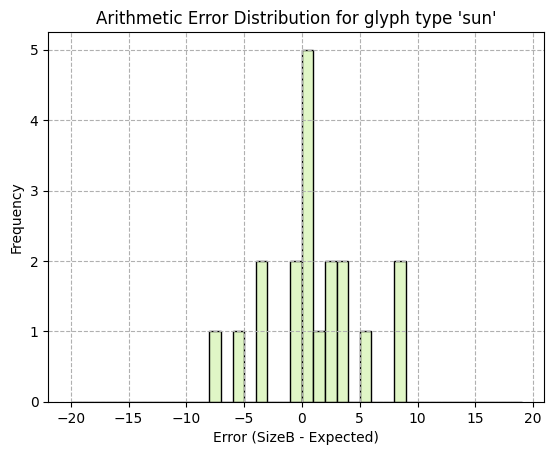

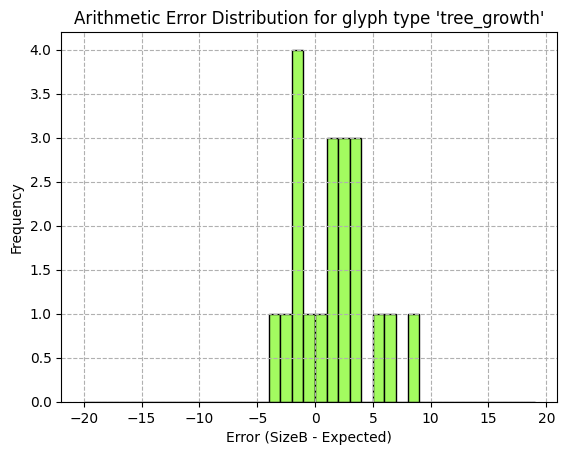

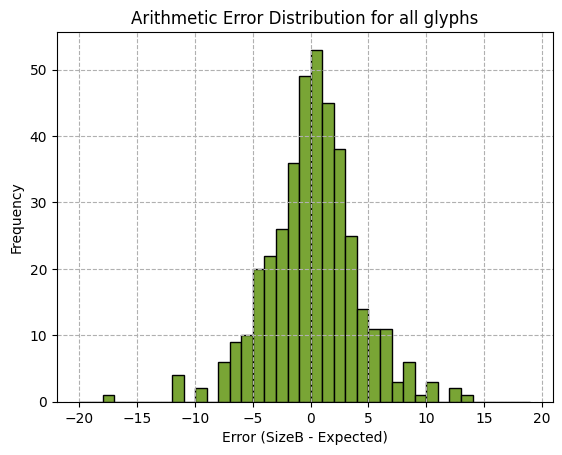

In [38]:
import numpy as np
import matplotlib.pyplot as plt

input_file = "filtered_results.csv"

def open_data_file(input_file):
    with open(input_file, "r") as f:
        lines = f.readlines()
        data_lines = [line.strip().split(",") for line in lines[1:]]  # csv header
    return data_lines

data_lines = open_data_file(input_file)

# uloz typy glyphu
GLYPH_TYPES = np.array([data_lines[i][1] for i in range(len(data_lines))])

# vypocet a plot aritmeticke chyby pro vsechny glyphy a pro kazdy typ glyphu zvlast
def compute_arithmetic_error():
    ar_diffs_all = [] 
    ar_diffs_by_type = {glyph_type: [] for glyph_type in np.unique(GLYPH_TYPES)}
    for i in range(len(data_lines)):
        A = int(data_lines[i][2])  
        B = int(data_lines[i][3])
        C = int(data_lines[i][4])
        expected = (A + C) / 2
        diff = B - expected
        ar_diffs_all.append(diff)

        glyph_type = data_lines[i][1]
        ar_diffs_by_type[glyph_type].append(diff)

    return ar_diffs_all, ar_diffs_by_type
    
ar_diffs_all, ar_diffs_by_type = compute_arithmetic_error()
# Plot pro kazdy typ glyphu
for glyph_type, diffs in ar_diffs_by_type.items():
    plt.figure()
    plt.hist(diffs, bins=np.arange(-20, 20, 1), edgecolor='black', color=np.random.rand(3))
    plt.xlabel("Error (SizeB - Expected)")
    plt.ylabel("Frequency")
    plt.title(f"Arithmetic Error Distribution for glyph type '{glyph_type}'")
    plt.grid(linestyle='--')
    plt.show()

# Plot pro vsechny glyphy dohromady
plt.figure()
plt.hist(ar_diffs_all, bins=np.arange(-20, 20, 1), edgecolor='black', color=np.random.rand(3))
plt.xlabel("Error (SizeB - Expected)")
plt.ylabel("Frequency")
plt.title("Arithmetic Error Distribution for all glyphs")
plt.grid(linestyle='--')
plt.show()


In [39]:
from scipy.optimize import least_squares
import numpy as np

"""
1. Normalizace dat do intervalu <0, 1>
2. Pro nalezeni optimalniho gamma pouzijeme metodu nejmensich ctvercu,
    funkce least_squares z knihovny scipy vola funkci residuals_stimulus, ktera vraci rozdil mezi
    predikovanym B a skutecnym B -> least_squares hleda takove gamma, ktere minimalizuje tento rozdil
    - LS zkousi ruzne hodnoty gamma, pro kazdou hodnotu spocita chybu (residuals_stimulus)
    - optimalni gamma je ta, pro kterou je tato chyba minimalni
"""

EPS = 1e-9
MIN, MAX = 0.05, 3.0       

# normalizace dat do intervalu <0, 1>
def normalize_data(x):
    return np.clip(x/100.0, EPS, 1.0 - EPS)

# (a^gamma + c^gamma / 2)^(1/gamma)
# predikuje percepcni stred 
def predict_b_gamma(gamma, a, c):
    middle = (a**gamma + c**gamma) / 2
    return middle ** (1.0/gamma)

# chyba mezi predikovanym B a skutecnym B
def residuals_stimulus(gamma, a, b, c):
    return predict_b_gamma(gamma, a, c) - b 

# metodou nejmensich ctvercu najdeme optimalni gamma
def ls_find_gamma_stimulus(a, b, c):
    res = least_squares(residuals_stimulus, x0=1.0, bounds=(MIN, MAX), args=(a, b, c))
    return float(res.x[0])

# vypocet MAE (Mean Absolute Error)
def MAE(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def stats_per_glyph_type(a, b, c):
    rows = []
    g_all= ls_find_gamma_stimulus(a, b, c) # optimalni gamma pro vsechny glyphy
    mae_all = MAE(b, predict_b_gamma(g_all, a, c))
    rows.append(("All", len(b), mae_all, g_all))

    for t in set(GLYPH_TYPES):
        idx = (GLYPH_TYPES == t) # na jakych indexech je dany typ glyphu
        a_t= a[idx]
        b_t= b[idx]
        c_t= c[idx]
        g_t = ls_find_gamma_stimulus(a_t, b_t, c_t) # optimalni gamma pro dany typ glyphu
        mae_t = MAE(b_t, predict_b_gamma(g_t, a_t, c_t)) # chyba pro dany typ glyphu
        rows.append((t.capitalize(), len(b_t), mae_t, g_t)) 
    return rows

def print_table(rows):
    print("Exponential (x^gamma) model\n")
    print(f"{'Glyph':<25} {'N':<5} {'MAE':<10} {'Gamma':<10}")
    print("-" * 60)
    for row in rows:
        print(f"{row[0]:<25} {row[1]:<5} {row[2]:<10.4f} {row[3]:<10.5f}")

def pct_B_between_after_gamma(a,b,c,g):
    A,B,C = a**g, b**g, c**g
    low, high = np.minimum(A,C), np.maximum(A,C)
    return 100.0 * np.mean((B >= low) & (B <= high))

A = np.array([float(data_lines[i][2]) for i in range(len(data_lines))])
B = np.array([float(data_lines[i][3]) for i in range(len(data_lines))])
C = np.array([float(data_lines[i][4]) for i in range(len(data_lines))])

a = normalize_data(A)
b = normalize_data(B)
c = normalize_data(C)

rows = stats_per_glyph_type(a, b, c)
print_table(rows)

Exponential (x^gamma) model

Glyph                     N     MAE        Gamma     
------------------------------------------------------------
All                       398   0.0290     1.08764   
Square                    50    0.0218     0.96500   
Line                      59    0.0288     1.02531   
Polygon                   67    0.0386     1.14148   
Sun                       19    0.0300     0.91039   
Circular_progressbar      20    0.0277     0.18097   
Star                      65    0.0252     1.41531   
Beer                      20    0.0119     0.70271   
Circle                    58    0.0267     0.96661   
Flower                    20    0.0319     1.57720   
Tree_growth               20    0.0251     1.37837   


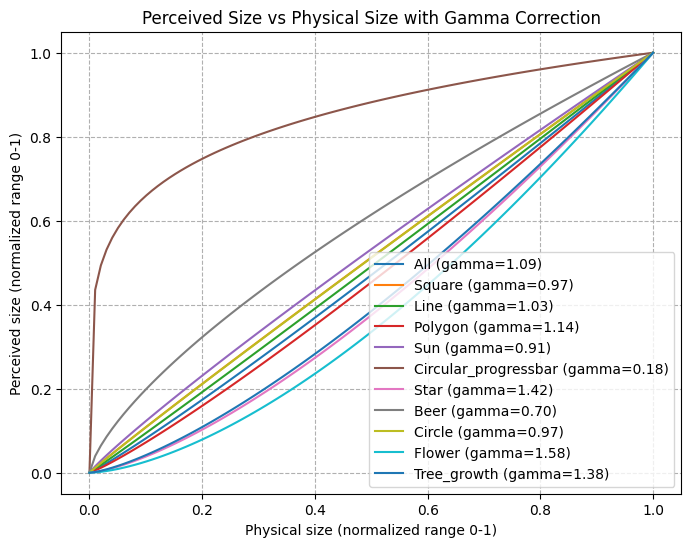

In [40]:
plt.figure(figsize=(8, 6))
x = np.linspace(0, 1, 100)
for row in rows:
    gamma = row[3]
    y = x ** gamma
    plt.xlabel("Physical size (normalized range 0-1)")
    plt.ylabel("Perceived size (normalized range 0-1)")
    plt.title("Perceived Size vs Physical Size with Gamma Correction")
    plt.grid(linestyle="--")
    plt.plot(x, y, label=f"{row[0]} (gamma={gamma:.2f})")
    plt.legend()


In [41]:
# omezena funkce (0, 1) polynomu 3. radu

A = np.array([float(data_lines[i][2]) for i in range(len(data_lines))])
B = np.array([float(data_lines[i][3]) for i in range(len(data_lines))])
C = np.array([float(data_lines[i][4]) for i in range(len(data_lines))])

a = normalize_data(A)
b = normalize_data(B)
c = normalize_data(C)

def cubic_constrained(x, b_par, c_par):
    x = np.asarray(x, float)
    return b_par*x + c_par*(x**2) + (1.0 - b_par - c_par)*(x**3)

def inv_cubic_constrained(y, b_par, c_par):
    y = np.atleast_1d(np.asarray(y, float)).ravel()
    out = np.empty_like(y)
    A = (1.0 - b_par - c_par)   # koef. u x^3
    B = c_par                   # u x^2
    C = b_par                   # u x
    for i, yi in enumerate(y):
        roots = np.roots([A, B, C, -yi])  # A x^3 + B x^2 + C x - yi = 0
        real = [r.real for r in roots if abs(r.imag) < 1e-9]
        in01 = [r for r in real if -1e-9 < r < 1.0 + 1e-9]
        if in01:
            # vyber ten, který po dosazení dává y nejblíž
            def fval(xx): return b_par*xx + c_par*xx**2 + (1.0-b_par-c_par)*xx**3
            xi = min(in01, key=lambda r: abs(fval(r) - yi))
        else:
            # nejbližší reálný a oříznout
            xi = min(real, key=lambda r: abs(r - np.clip(r, 0.0, 1.0))) if real else 0.0
        out[i] = np.clip(xi, 0.0, 1.0)
    return out.reshape(y.shape)

def predict_b_cubic_constrained(b_par, c_par, A, C):
    mid = 0.5*(cubic_constrained(A, b_par, c_par) +
               cubic_constrained(C, b_par, c_par))
    return inv_cubic_constrained(mid, b_par, c_par)

def residuals_cubic_constrained(theta, A, B, C):
    b_par, c_par = float(theta[0]), float(theta[1])
    B_pred = predict_b_cubic_constrained(b_par, c_par, A, C)
    return np.ravel(B_pred - B)

CC_THETA0 = np.array([1.0, 0.0], dtype=float)     
CC_LOW    = np.array([0.2, -1.5], dtype=float)
CC_HIGH   = np.array([1.8,  1.5], dtype=float)

def ls_find_params_cubic_constrained(A, B, C):
    res = least_squares(
        residuals_cubic_constrained,
        x0=CC_THETA0, bounds=(CC_LOW, CC_HIGH),
        args=(np.asarray(A,float), np.asarray(B,float), np.asarray(C,float)),
        max_nfev=5000
    )
    return res.x  # [b, c]

def stats_per_glyph_type_cubic_constrained(A, B, C):
    A = np.asarray(A, float).ravel()
    B = np.asarray(B, float).ravel()
    C = np.asarray(C, float).ravel()
    rows = []

    b0, c0 = ls_find_params_cubic_constrained(A, B, C)
    B_pred_all = predict_b_cubic_constrained(b0, c0, A, C)
    mae_all = MAE(B, B_pred_all)
    rows.append(("All", B.size, mae_all, 0.0, b0, c0, 1.0 - b0 - c0)) 

    for t in np.unique(GLYPH_TYPES):
        idx = (GLYPH_TYPES == t)
        if not np.any(idx): 
            continue
        A_t, B_t, C_t = A[idx], B[idx], C[idx]
        b_t, c_t = ls_find_params_cubic_constrained(A_t, B_t, C_t)
        B_pred_t = predict_b_cubic_constrained(b_t, c_t, A_t, C_t)
        mae_t = MAE(B_t, B_pred_t)
        rows.append((t.capitalize(), B_t.size, mae_t, 0.0, b_t, c_t, 1.0 - b_t - c_t))
    return rows

def print_table_cubic_constrained(rows):
    print("3rd grade polynomial model\n")
    print(f"{'Glyph':<25} {'N':<5} {'MAE':<10} {'a':<10} {'b':<10} {'c':<10} {'d':<10}")
    print("-" * 90)
    for name, n, mae, a_, b_, c_, d_ in rows:
        print(f"{name:<25} {n:<5} {mae:<10.4f} {a_:<10.5f} {b_:<10.5f} {c_:<10.5f} {d_:<10.5f}")

rows_cc = stats_per_glyph_type_cubic_constrained(a, b, c)
print_table_cubic_constrained(rows_cc)

3rd grade polynomial model

Glyph                     N     MAE        a          b          c          d         
------------------------------------------------------------------------------------------
All                       398   0.0288     0.00000    0.78105    0.64852    -0.42957  
Beer                      20    0.0103     0.00000    1.69287    -1.16002   0.46714   
Circle                    58    0.0259     0.00000    0.96505    0.48534    -0.45039  
Circular_progressbar      20    0.0253     0.00000    1.80000    -0.90449   0.10449   
Flower                    20    0.0290     0.00000    0.45858    0.07604    0.46538   
Line                      59    0.0282     0.00000    0.95834    0.62708    -0.58542  
Polygon                   67    0.0375     0.00000    0.54792    1.32330    -0.87122  
Square                    50    0.0217     0.00000    1.03328    0.11343    -0.14671  
Star                      65    0.0227     0.00000    0.35573    1.50000    -0.85573  
Sun        

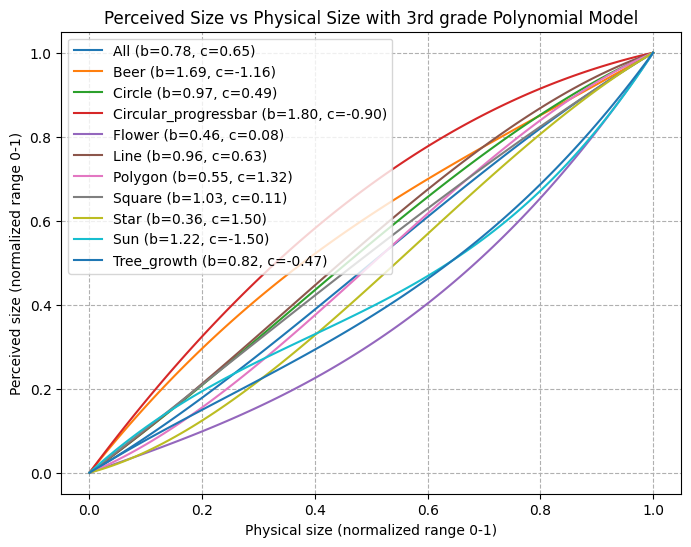

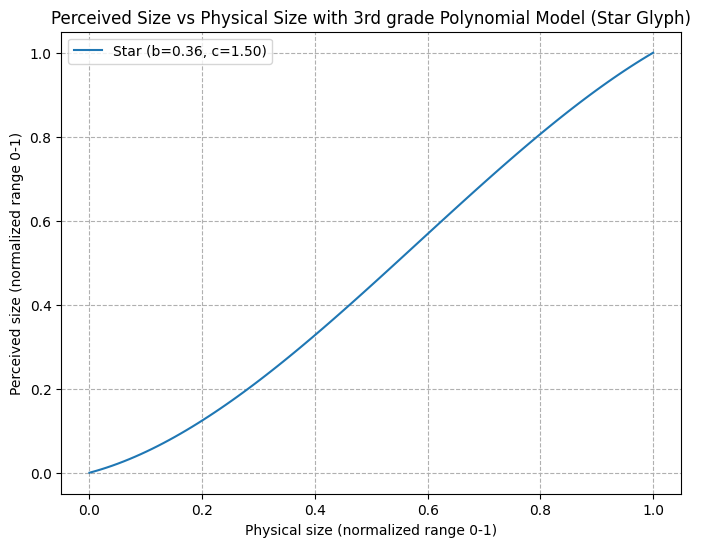

In [42]:
plt.figure(figsize=(8,6))
x = np.linspace(0, 1, 100)
for row in rows_cc:
    b, c = row[4], row[5]
    y = cubic_constrained(x, b, c)
    plt.xlabel("Physical size (normalized range 0-1)")
    plt.ylabel("Perceived size (normalized range 0-1)")
    plt.title("Perceived Size vs Physical Size with 3rd grade Polynomial Model")
    plt.grid(linestyle="--")
    plt.plot(x, y, label=f"{row[0]} (b={b:.2f}, c={c:.2f})")
    plt.legend()
plt.show()

#plot jen pro hvezdu
plt.figure(figsize=(8,6))
x = np.linspace(0, 1, 100)
for row in rows_cc:
    if row[0] != "Star":
        continue
    b, c = row[4], row[5]
    y = cubic_constrained(x, b, c)
    plt.xlabel("Physical size (normalized range 0-1)")
    plt.ylabel("Perceived size (normalized range 0-1)")
    plt.title("Perceived Size vs Physical Size with 3rd grade Polynomial Model (Star Glyph)")
    plt.grid(linestyle="--")
    plt.plot(x, y, label=f"{row[0]} (b={b:.2f}, c={c:.2f})")
    plt.legend()
plt.show()

In [43]:
# body Ai, Bi, Ci
# Ai = [sizeA, cubic(A)]
# Ci = [sizeC, cubic(C)]
# Bi = [sizeB, (cubic(A) + cubic(C)) / 2]
N = 400

A = np.array([float(data_lines[i][2]) for i in range(len(data_lines))])
B = np.array([float(data_lines[i][3]) for i in range(len(data_lines))])
C = np.array([float(data_lines[i][4]) for i in range(len(data_lines))])

a = normalize_data(A)
b = normalize_data(B)
c = normalize_data(C)

def beak_plot(A, B, C, coeffs, title="Beak plot for all glyphs"):

    b_coeff, c_coeff = coeffs

    fig, ax = plt.subplots(figsize=(8,6))

    x = np.linspace(0, 1, N)    
    y = cubic_constrained(x, b_coeff, c_coeff)

    ax.plot(x, y, label=f"Model: a=0, b={b_coeff:.3f}, c={c_coeff:.3f}, d=1-b-c", color='blue')

    for Ai, Bi, Ci in zip(A, B, C):
        yA = cubic_constrained(Ai, b_coeff, c_coeff)
        yC = cubic_constrained(Ci, b_coeff, c_coeff)
        yB = 0.5 * (yA + yC)

        ax.scatter([Ai, Ci], [yA, yC], color='black', s=5)  # A and C points
        ax.scatter([Bi], [yB], color='red', s=10)         # B point

        ax.plot([Ai, Bi], [yA, yB], color='gray', linewidth=0.2)
        ax.plot([Ci, Bi], [yC, yB], color='gray', linewidth=0.2)

    ax.set_xlabel("Physical size (normalized range 0-1)")
    ax.set_ylabel("y = polynomial3(x)")
    ax.set_title(title)
    ax.grid(linestyle='--', alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

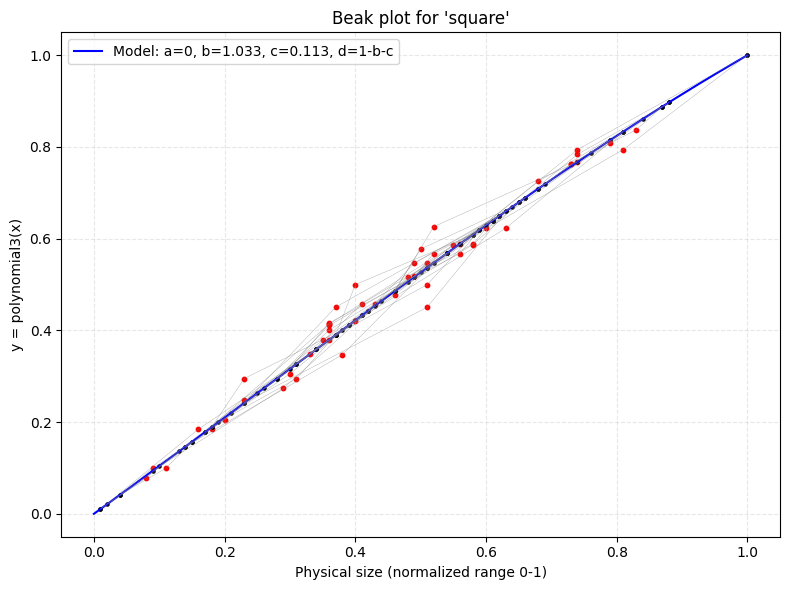

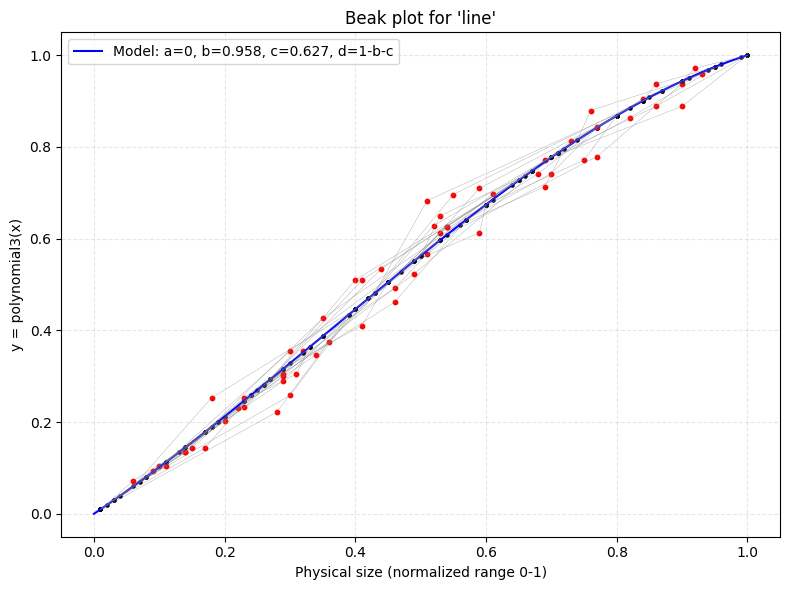

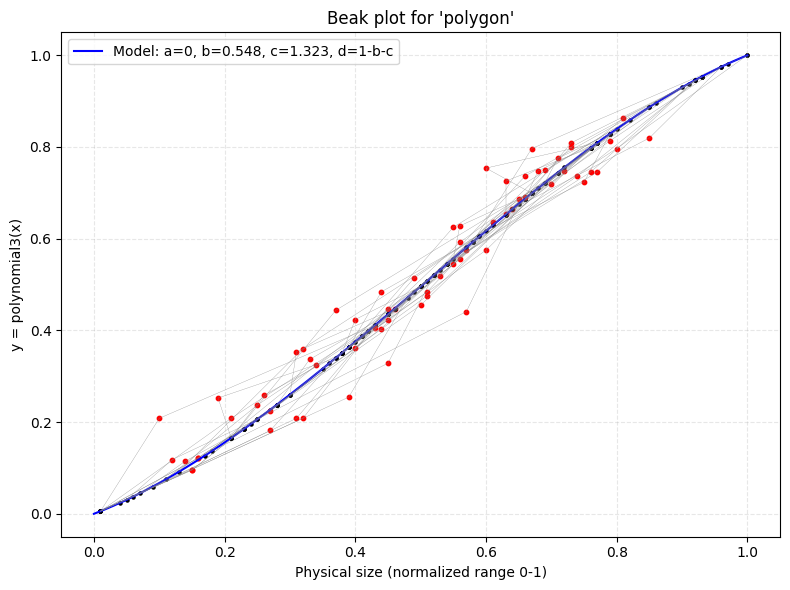

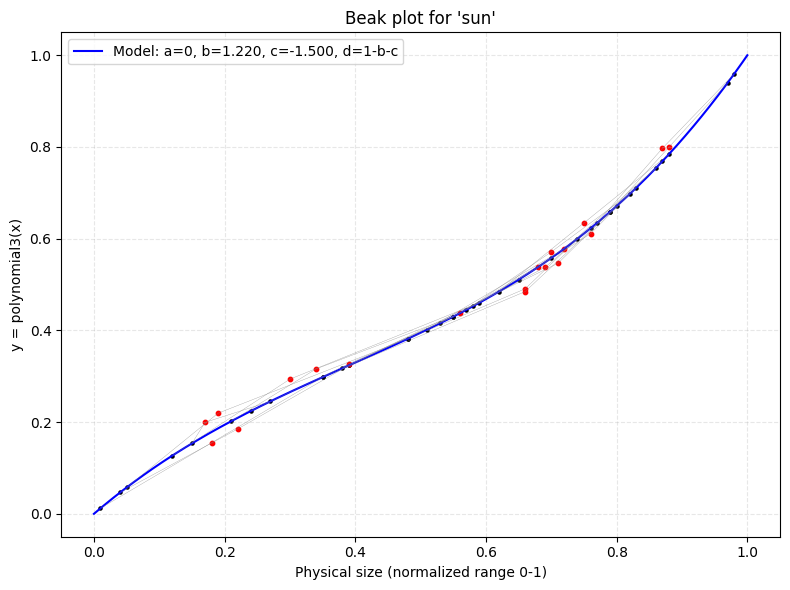

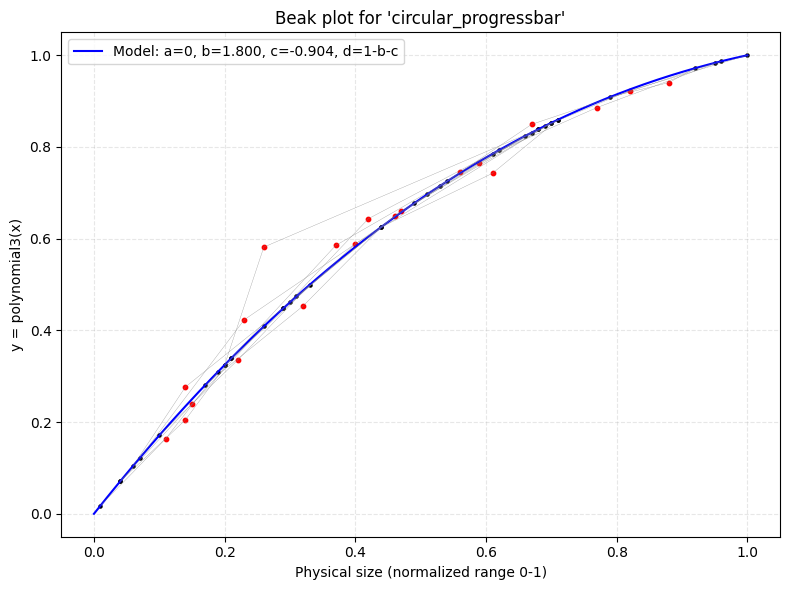

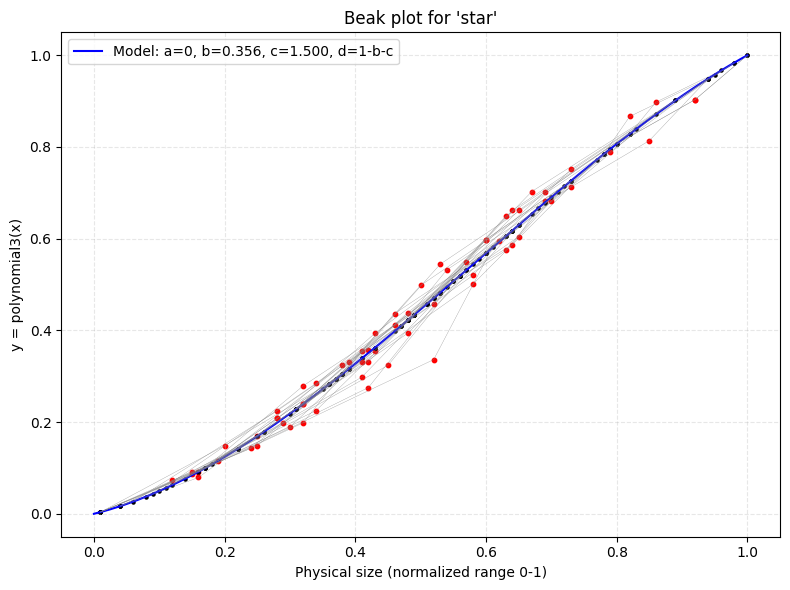

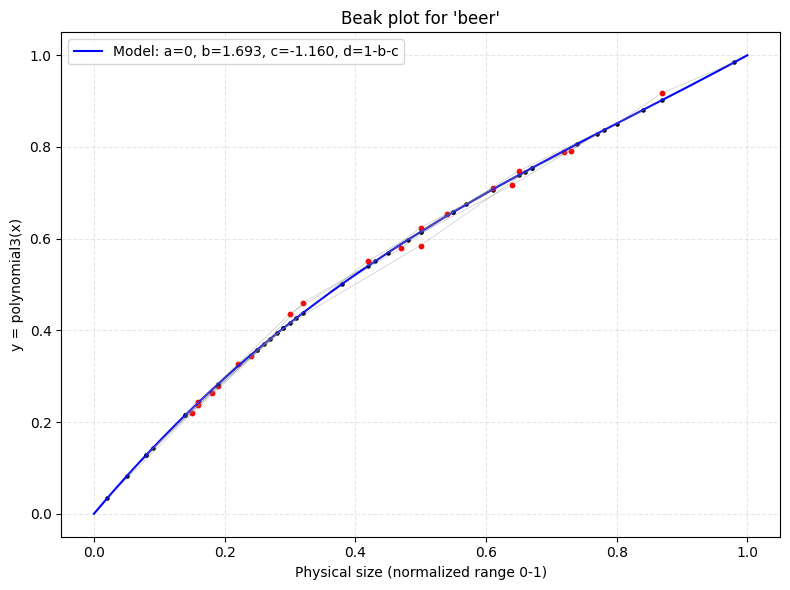

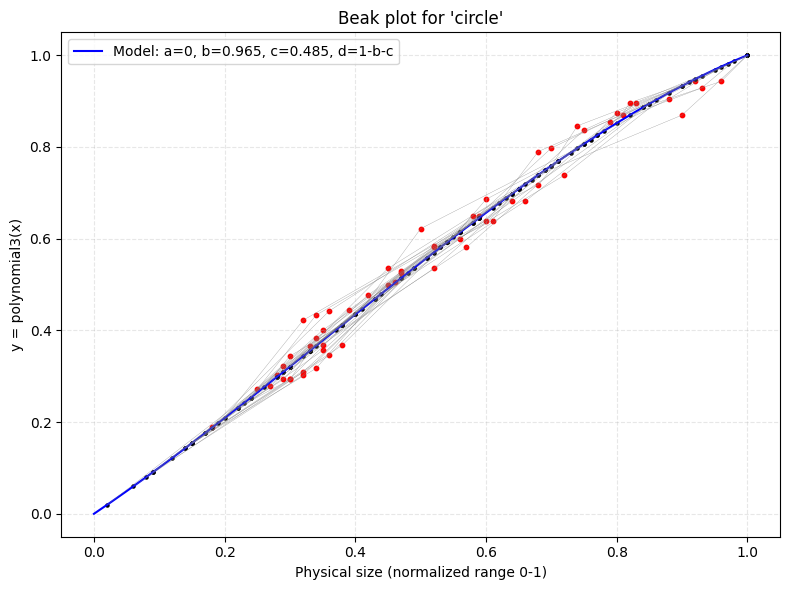

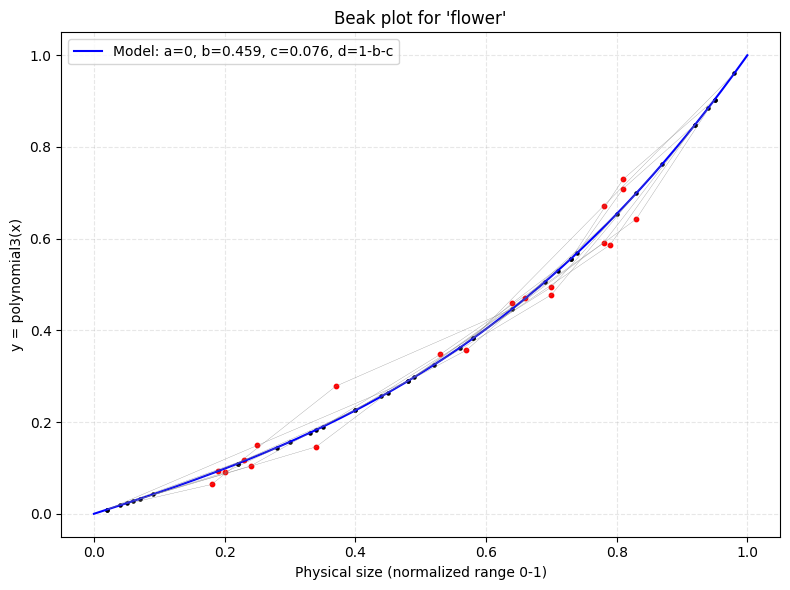

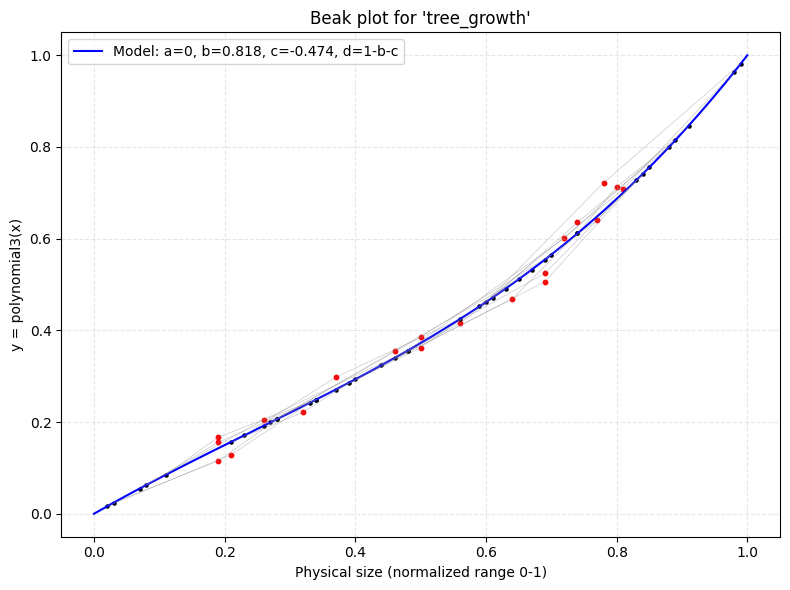

In [44]:
for glyph in set(GLYPH_TYPES):
    idx = (GLYPH_TYPES == glyph)
    
    a_t= a[idx]
    b_t= b[idx]
    c_t= c[idx]

    b_coeff, c_coeff = ls_find_params_cubic_constrained(a_t, b_t, c_t)
    beak_plot(a_t, b_t, c_t, (b_coeff, c_coeff), title=f"Beak plot for '{glyph}'")